In [1]:
from gensim.models import word2vec
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from load_transcripts import load_transcripts

In [3]:
transcript = load_transcripts(path='../spotify-podcasts-2020/podcasts-transcripts/',limit=1)[0]

100%|██████████| 1/1 [00:00<00:00, 18.87it/s]


In [4]:
# Split the transcript into sentences of words
sentences = transcript.split('.')
# Split each sentence into words and lowercase them
words = []
for sentence in sentences:
    words.append(sentence.split(' '))

# lowercase all the words
for i in range(len(words)):
    for j in range(len(words[i])):
        words[i][j] = words[i][j].lower()

# Train a word2vec model
model = word2vec.Word2Vec(words, vector_size=100, window=3, min_count=1,)

wrdvecs = pd.DataFrame(model.wv.vectors, index=model.wv.index_to_key)

In [5]:
print(wrdvecs.shape)

(1659, 100)


In [13]:
from textsplit.tools import SimpleSentenceTokenizer

sentence_tokenizer = SimpleSentenceTokenizer()

In [14]:
%matplotlib inline
from textsplit.tools import get_penalty, get_segments
from textsplit.algorithm import split_optimal, split_greedy, get_total

  0%|          | 0/1 [01:18<?, ?it/s]


CountVectorizer(vocabulary=Index(['', 'i', 'and', 'like', 'the', 'a', 'you', 'to', 'it', 'that',
       ...
       'admit', 'disagree', 'marriage', 'thing?\n\n', 'letter', 'go?',
       'teacher?', 'what's', 'misses', 'oh\n\n'],
      dtype='object', length=1659))
penalty 0.00
661 sentences, 106 segments, avg 6.24 sentences per segment
optimal score 6233.92, greedy score 6233.56
ratio of scores 1.0001


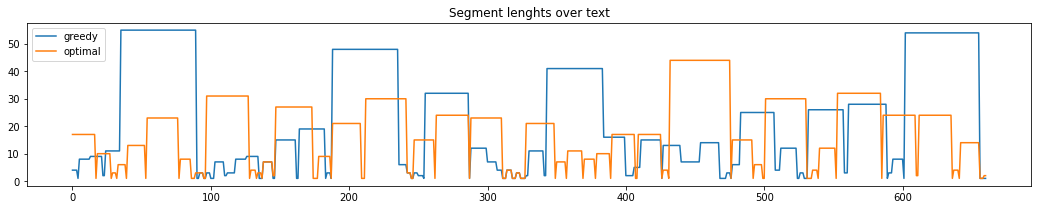

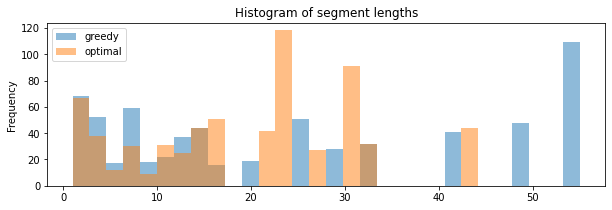

In [15]:
segment_len = 30

sentenced_text = sentence_tokenizer(transcript)
vecr = CountVectorizer(vocabulary=wrdvecs.index)

print(vecr)

sentence_vectors = vecr.transform(sentenced_text).dot(wrdvecs)

penalty = get_penalty([sentence_vectors], segment_len)
print('penalty %4.2f' % penalty)

optimal_segmentation = split_optimal(sentence_vectors, penalty, seg_limit=250)
segmented_text = get_segments(sentenced_text, optimal_segmentation)

print('%d sentences, %d segments, avg %4.2f sentences per segment' % (
    len(sentenced_text), len(segmented_text), len(sentenced_text) / len(segmented_text)))

with open('test' + '.seg', 'wt') as f:
    for i, segment_sentences in enumerate(segmented_text):
        segment_str = ' // '.join(segment_sentences)
        gain = optimal_segmentation.gains[i] if i < len(segmented_text) - 1 else 0
        segment_info = ' [%d sentences, %4.3f] ' % (len(segment_sentences), gain) 
        print(segment_str + '\n8<' + '=' * 30 + segment_info + "=" * 30, file=f)

greedy_segmentation = split_greedy(sentence_vectors, max_splits=len(optimal_segmentation.splits))
greedy_segmented_text = get_segments(sentenced_text, greedy_segmentation)
lengths_optimal = [len(segment) for segment in segmented_text for sentence in segment]
lengths_greedy = [len(segment) for segment in greedy_segmented_text for sentence in segment]
df = pd.DataFrame({'greedy':lengths_greedy, 'optimal': lengths_optimal})
df.plot.line(figsize=(18, 3), title='Segment lenghts over text')
df.plot.hist(bins=30, alpha=0.5, figsize=(10, 3), title='Histogram of segment lengths')

totals = [get_total(sentence_vectors, seg.splits, penalty) 
          for seg in [optimal_segmentation, greedy_segmentation]]
print('optimal score %4.2f, greedy score %4.2f' % tuple(totals))
print('ratio of scores %5.4f' % (totals[0] / totals[1]))